# 10X Visium HE imaged data

This tutorial will guide you through the process of running SpaHDmap on your data. Our example data is a 10X Visium ST dataset MPBS-01 sequenced from an adult mouse brain posterior section comprising a H&E image, we will take the H&E image and the spot expression data as input to run SpaHDmap. could be downloaded from [10X Genomics](https://www.10xgenomics.com/datasets/mouse-brain-serial-section-1-sagittal-posterior-1-standard-1-1-0).

## 1. Import necessary libraries

Please install SpaHDmap first.

`!pip install SpaHDmap`

In [1]:
import torch
import numpy as np
import scanpy as sc

import SpaHDmap as hdmap

## 2. Set the parameters and paths

In this section, we will set the parameters and paths for the SpaHDmap model, including:

**Parameters**:
- `rank`: the rank / number of components of the NMF model
- `seed`: the random seed
- `verbose`: whether to print the log information

**Paths**:
- `root_path`: the root path of the experiment
- `project`: the name of the project
- `results_path`: the path to save the results

### Parameters settings

By default, we set the `rank` to 20, the `seed` to 123, and the `verbose` to True. You can modify the parameters according to your data.

In [2]:
rank = 20
seed = 123
verbose = True

np.random.seed(seed)
torch.manual_seed(seed)

### Paths settings

These paths are set with respect to the current directory. You can modify the paths according to your data.

In [3]:
root_path = '../experiments/'
project = 'MPBS01'

results_path = f'{root_path}/{project}/Results_Rank{rank}/'

## 3. Load the data and pre-process

The data used in this tutorial is a 10X Visium ST dataset MPBS-01 sequenced from an adult mouse brain sagittal section, could be downloaded from [10X Genomics](https://www.10xgenomics.com/datasets/mouse-brain-serial-section-1-sagittal-posterior-1-standard-1-1-0).

Next, we set the scale rate and radius. You can also provide the `scale_rate` and `radius` according to your data.

In [4]:
radius = 45
scale_rate = 1

To load and preprocess the data, we need to provide the following information:
- `section_name`: the name of the section
- `image_path`: the path to the image.
- `adata`: the anndata object that contains the expression data (if provided, `visium_path`, `spot_exp_path` and `spot_coord_path` will be ignored)
- If you want to load data from your local 10X Visium folder, you can provide `visium_path` to load the 10X Visium data directly.
- Otherwise, you need to provide the `spot_coord_path` and `spot_exp_path` to load the spot coordinates and expression data.
- `scale_rate`: the scale rate of the input images
- `radius`: the radius of the spots
- `create_mask`: whether to create the mask, default is True
- `swap_coord`: whether to swap the coordinates, default is True

We recommend to download / load the data using the api `sc.datasets.visium_sge` from scanpy, and set `include_hires_tiff=True` to download the hires image. In this case, this data will be saved locally in the folder `data/id of the section`, and next time you can load the data from the local folder.

In [7]:
section_id = 'V1_Mouse_Brain_Sagittal_Posterior'

# Download the data from the 10X website (set include_hires_tiff=True to download the hires image)
adata = sc.datasets.visium_sge(section_id, include_hires_tiff=True)
image_path = adata.uns["spatial"][section_id]["metadata"]["source_image_path"]

# or load the data from a local folder
# adata = sc.read_visium(f'data/{section_id}', count_file='filtered_feature_bc_matrix.h5')
# image_path = f'data/{section_id}/image.tif'

/home/qk/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/qk/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Then we can will preprocess the data using `prepare_stdata`, including normalizing the expression data, swapping the coordinates, selecting the SVGs. Default, we will find 3,000 SVGs according to the Moran's I index by default, or you can set `method='sparkx'` to find SVGs based on the Spark-X method.

*Note*: If you download the 10X Visium data using the `sc.datasets.visium_sge` function, the coordinates will be swapped by default, and the radius will be calculated through `radius = round(adata.uns['spatial'][section_id]['scalefactors']['spot_diameter_fullres'] / 2)`. Meanwhile, it will be fine if you provide an adata object whose expression matrix has already been normalized (but not be scaled, the expression matrix has to be non-negative), this function will recognize the normalized expression data automatically.

In [8]:
# Load the data from the 10X Visium folder
mouse_posterior = hdmap.prepare_stdata(adata=adata,
                                       section_name='mouse_posterior',
                                       image_path=image_path,
                                       scale_rate=scale_rate)

hdmap.select_svgs(mouse_posterior, n_top_genes=3000, method='moran')

*** Reading and preparing AnnData for section mouse_posterior ***
Spot radius found in AnnData: 45
Pre-processing gene expression data for 3355 spots and 32285 genes.
Swapping x and y coordinates.
Processing image, seems to be HE image.


/home/qk/anaconda3/lib/python3.11/site-packages/squidpy/gr/_utils.py:194: ImplicitModificationWarning: Setting element `.obsp['spatial_connectivities']` of view, initializing view as actual.
  obj[key] = data


Selected 3000 SVGs.


In [9]:
mouse_posterior

STData object for section: mouse_posterior
Number of spots: 3355
Number of genes: 3000
Image shape: (3, 11607, 11620)
Scale rate: 1
Spot radius: 45
Image type: HE
Available scores: 

    Alternatively, you can load the data from scratch with the paths of spot coordinates, expression and image provided.

These data can be downloaded from the 10X Genomics website in:
- spot coordinates: `Output and supplemental files -> Spatial imaging data -> tissue_positions_list.csv`, please make sure that the first column is the spot names and the last two columns are the coordinates.
- expression: `Output and supplemental files -> Feature / barcode matrix (both filtered and raw are fine)`, a hdf5 file or a csv file with the first row as the gene names and the first column as the spot names.
- image: `Input files -> Image (TIFF)`.

Then you can load the data using the following code:

In [5]:
# Load the data (This data has been preprocessed, including normalization, swapping the coordinates and selecting SVGs)
'''
mouse_posterior = hdmap.prepare_stdata(section_name='mouse_posterior',
                                       image_path='../data/MPBS01/HE.tif',
                                       spot_coord_path='../data/MPBS01/spot_coord.csv',
                                       spot_exp_path='../data/MPBS01/expression_nor.csv', # Has been normalized and selected the SVGs
                                       scale_rate=scale_rate,
                                       radius=radius, # Has to be provided if loading from scratch
                                       swap_coord=False) #  The coordinates have been swapped
'''

*** Reading and preparing data from scratch for section mouse_posterior ***
Pre-processing gene expression data for 3355 spots and 3000 genes.


/home/qk/projects/SpaHDmap/SpaHDmap/data/data_util.py:259: UserWarning: Coordinates are not swapped. Make sure the coordinates are in the correct order.
  warnings.warn("Coordinates are not swapped. Make sure the coordinates are in the correct order.")
/home/qk/projects/SpaHDmap/SpaHDmap/data/data_util.py:263: UserWarning: Data seems to be already normalized, skipping normalization.
  warnings.warn("Data seems to be already normalized, skipping normalization.")


Processing image, seems to be HE image.


In [6]:
mouse_posterior

STData object for section: mouse_posterior
Number of spots: 3355
Number of genes: 3000
Image shape: (3, 11607, 11620)
Scale rate: 1
Spot radius: 45
Image type: HE
Available scores: 

## 4. Run SpaHDmap

First, we need to initialize the Mapper object to run SpaHDmap.

In this step, sections will be preprocessed, including:
- Split the image into patches: the image will be split into patches based on the spot coordinates and the radius
- Create pseudo spots: the pseudo spots will be created based on the spot coordinates, number of sequenced spots and radius

The Mapper object contains the following attributes:
- `section`: the section object
- `results_path`: the path to save the results
- `rank`: the rank / number of components of the NMF model, default is 20
- `reference`: dictionary to assign the reference section for each query section, default is None (only for multi-sections)
- `verbose`: whether to print the log information, default is True

In [10]:
# Initialize the SpaHDmap runner
mapper = hdmap.Mapper(mouse_posterior, results_path=results_path, rank=rank, verbose=verbose)

*** Using GPU ***
*** Preparing the tissue splits and creating pseudo spots... ***
For section mouse_posterior, divide the tissue into 1413 sub-tissues, and create 15000 pseudo spots


### Run all steps in one function

We can run all steps in one function `run_SpaHDmap` after obtaining the Mapper object.

In [11]:
# Run all steps in one function
mapper.run_SpaHDmap(save_score=False, save_model=True, load_model=True, visualize=True)

# If you want to lower the GPU memory usage, you can set `batch_size` to a smaller number
# mapper.args.batch_size = 16 (default 32)
# mapper.run_SpaHDmap(save_score=False, save_model=True, visualize=False)

Step 1: Run NMF
*** Performing NMF... ***
*** Visualizing and saving the embeddings of NMF... ***
Step 2: Pre-train the SpaHDmap model
[Iter: 200 / 5000], Epoch: 5, Loss: 0.059221, Learning rate: 3.984269e-04
[Iter: 400 / 5000], Epoch: 9, Loss: 0.001755, Learning rate: 3.937323e-04
[Iter: 600 / 5000], Epoch: 14, Loss: 0.000886, Learning rate: 3.859904e-04
[Iter: 800 / 5000], Epoch: 18, Loss: 0.000619, Learning rate: 3.753232e-04
[Iter: 1000 / 5000], Epoch: 23, Loss: 0.000483, Learning rate: 3.618989e-04
[Iter: 1200 / 5000], Epoch: 27, Loss: 0.000385, Learning rate: 3.459292e-04
[Iter: 1400 / 5000], Epoch: 32, Loss: 0.000337, Learning rate: 3.276661e-04
[Iter: 1600 / 5000], Epoch: 36, Loss: 0.000306, Learning rate: 3.073974e-04
[Iter: 1800 / 5000], Epoch: 40, Loss: 0.000277, Learning rate: 2.854430e-04
[Iter: 2000 / 5000], Epoch: 45, Loss: 0.000255, Learning rate: 2.621489e-04
[Iter: 2200 / 5000], Epoch: 49, Loss: 0.000229, Learning rate: 2.378826e-04
[Iter: 2400 / 5000], Epoch: 54, Los

Parameters of `run_SpaHDmap` are as follows:
- `save_score`: whether to save the embeddings, default is False
- `save_model`: whether to save the model, default is True
- `load_model`: whether to load the model if it has been trained and saved, default is True
- `visualize`: whether to visualize the results, default is True

Or you can run each step separately as follows to get a detailed understanding of the SpaHDmap model.

### Run NMF to get the initial spot score and loading matrix

We need to run NMF on the concatenated data to get the initial spot score and loading matrix (metagene).

If `save_score=True` (default False), the `NMF` score will be saved in `results_path/section_name/NMF/NMF_score.npy`, using numpy.float32 type.

The loading matrix will be saved in `results_path/V_para_NMF.csv`

In [12]:
# Run NMF on concatenated data
mapper.get_NMF_score(save_score=False)

print(mouse_posterior.scores['NMF'].shape)

*** Performing NMF... ***
(3355, 20)


We can visualize the NMF score for a specific index, `sections` can be the section or the name of the section or None.
 
In this case, we visualize the NMF score for the section 'mouse_posterior' and the index 2.

*** Visualizing and saving the embeddings of NMF... ***


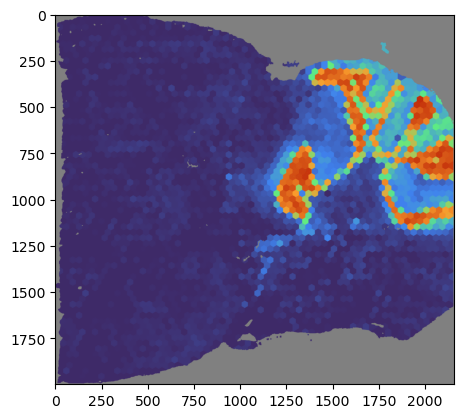

In [13]:
mapper.visualize(mouse_posterior, use_score='NMF', index=2)
# mapper.visualize('mouse_posterior', use_score='NMF', index=2) # visualize given the name
# mapper.visualize(use_score='NMF', index=2) # ignore the section name if only one section

Also, we can visualize without specifying the index, all NMF scores will be saved in `results_path/section_name/NMF`.

In [14]:
# Save all NMF scores into `results_path/section_name/NMF`
mapper.visualize(use_score='NMF')

*** Visualizing and saving the embeddings of NMF... ***


### Pre-train the SpaHDmap model

In this step, we pre-train the SpaHDmap model based on the image prediction to get the sub-image embedding, which will be used to create the graph between spots, and used as the initial parameters for later training.

If `save_model=True` (default True), the pre-trained model will be saved in `{results_path}/models/pretrain_model.pth`

In [15]:
# Pre-train the SpaHDmap model via reconstructing the HE image
mapper.pretrain(save_model=True)

*** Pre-trained model found at ../experiments//MBSS1/Results_Rank20//models//pretrained_model.pth, loading... ***


### Train GCN to get smoothness score for sequenced and pseudo spots

In this step, we create a graph based on the spot coordinates and the sub-image embedding.

Then we train a Graph Auto-encoder model to get the smoothness NMF score (named GCN score) for sequenced and pseudo spots based on reconstructing the NMF score of sequenced spots.

If `save_score=True`, the `GCN` score will be saved in `results_path/section_name/GCN/GCN_score.npy`, using numpy.float32 type.

In addition, we refine the metagene matrix based on the smoothness score, which will be used as the initial metagene for SpaHDmap.

In [16]:
# Train the GCN model and get GCN score
mapper.get_GCN_score(save_score=False)

print(mouse_posterior.scores['GCN'].shape)

*** Performing GCN... ***
*** Training GCN for mouse_posterior... ***
[Iter: 200 / 5000], Loss: 0.022442, Learning rate: 4.985215e-03
[Iter: 400 / 5000], Loss: 0.006313, Learning rate: 4.941093e-03
[Iter: 600 / 5000], Loss: 0.005326, Learning rate: 4.868331e-03
[Iter: 800 / 5000], Loss: 0.005172, Learning rate: 4.768075e-03
[Iter: 1000 / 5000], Loss: 0.005101, Learning rate: 4.641907e-03
[Iter: 1200 / 5000], Loss: 0.005058, Learning rate: 4.491816e-03
[Iter: 1400 / 5000], Loss: 0.005023, Learning rate: 4.320170e-03
[Iter: 1600 / 5000], Loss: 0.004996, Learning rate: 4.129675e-03
[Iter: 1800 / 5000], Loss: 0.004970, Learning rate: 3.923336e-03
[Iter: 2000 / 5000], Loss: 0.004949, Learning rate: 3.704407e-03
[Iter: 2200 / 5000], Loss: 0.004932, Learning rate: 3.476340e-03
[Iter: 2400 / 5000], Loss: 0.004916, Learning rate: 3.242732e-03
[Iter: 2600 / 5000], Loss: 0.004902, Learning rate: 3.007268e-03
[Iter: 2800 / 5000], Loss: 0.004891, Learning rate: 2.773660e-03
[Iter: 3000 / 5000], Los

*** Visualizing and saving the embeddings of GCN... ***


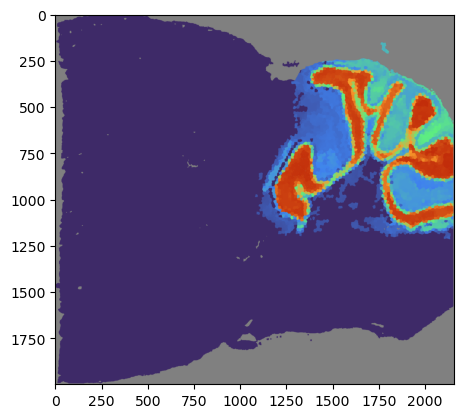

In [17]:
# Visualize the GCN score
mapper.visualize(mouse_posterior, use_score='GCN', index=2)

In [18]:
# Save all GCN scores into `results_path/section_name/GCN`
mapper.visualize(use_score='GCN')

*** Visualizing and saving the embeddings of GCN... ***


In [19]:
# The refined metagene matrix based on the GCN score
print(mapper.metagene_GCN.shape)

(20, 3000)


### Train SpaHDmap

In this step, we train the SpaHDmap model based on the image prediction and expression reconstruction.

First, we need to get the VD score of section, which contains pixel-wise score based on copying the nearest spot's GCN score (Voronoi Diagram), will be fused with score predicted from image.

In [20]:
# Get the VD score
mapper.get_VD_score(use_score='GCN')

Then we train the SpaHDmap model.

In [21]:
# Train the SpaHDmap model
# If the model has been trained and saved, mapper will load the model directly
mapper.train(save_model=True, load_model=True)

*** Trained model found at ../experiments//MBSS1/Results_Rank20//models//trained_model.pth, loading... ***


After training, we can get all pixel-wise SpaHDmap scores. If `save_score=True`, the `SpaHDmap` score will be saved in `results_path/section_name/SpaHDmap/SpaHDmap_score.npy`, using numpy.float16 type to save space.

In [22]:
# Get the SpaHDmap score
mapper.get_SpaHDmap_score(save_score=False)

print(mouse_posterior.scores['SpaHDmap'].shape)

*** Extracting SpaHDmap scores for mouse_posterior... ***
(20, 7998, 8623)


Next, we can visualize the SpaHDmap score for a specific section and index.

*** Visualizing and saving the embeddings of SpaHDmap... ***


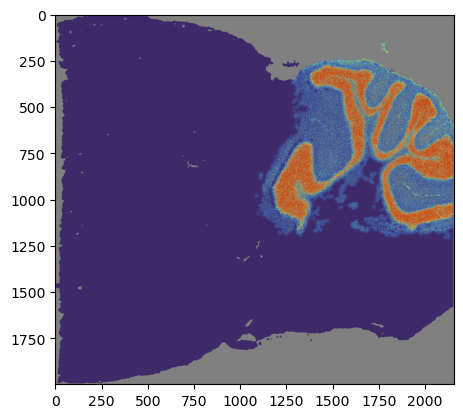

In [23]:
# Visualize the SpaHDmap score
mapper.visualize(mouse_posterior, use_score='SpaHDmap', index=2)

Different from the NMF and GCN scores, the SpaHDmap score is a pixel-wise score. For the purposes of reducing storage size and enabling visualization, we save the SpaHDmap scores as images with int type (0-255):
- The gray value of each pixel represents the score of that pixel and is stored in `results_path/section_name/SpaHDmap/gray`.
- The color image shows the intensity of the score. It is stored in `results_path/section_name/SpaHDmap/color` after being scaled by a rate of 4.

In [24]:
# Save all SpaHDmap scores into `results_path/section_name/SpaHDmap`
mapper.visualize(use_score='SpaHDmap')

*** Visualizing and saving the embeddings of SpaHDmap... ***


Now NMF, GCN and SpaHDmap scores are available now.

In [25]:
mouse_posterior

STData object for section: mouse_posterior
Number of spots: 3355
Number of genes: 3000
Image shape: (3, 11607, 11620)
Scale rate: 1
Spot radius: 45
Image type: HE
Available scores: NMF, GCN, VD, SpaHDmap

The final metagene matrix is stored in the `metagene` attribute of the Mapper object.

In [26]:
mapper.metagene.head()

,Embedding_1,Embedding_2,Embedding_3,Embedding_4,Embedding_5,Embedding_6,Embedding_7,Embedding_8,Embedding_9,Embedding_10,Embedding_11,Embedding_12,Embedding_13,Embedding_14,Embedding_15,Embedding_16,Embedding_17,Embedding_18,Embedding_19,Embedding_20
Pcp2,0.346328,0.429389,2.570228,1.164511,0.545917,0.000000,0.000000,0.133457,0.317487,0.257019,0.249951,0.000000,0.019139,0.214179,2.673292,3.402495,0.516575,0.284513,0.700011,0.000000
Mbp,2.798865,4.019177,3.365201,1.781176,3.847497,1.729764,0.690823,3.888377,0.979917,0.634742,1.437323,4.024412,1.510051,1.809176,0.553109,2.083190,1.796623,2.460258,5.982219,1.720192
Nrgn,2.711134,0.164730,0.395043,0.149537,0.021984,1.095392,1.326448,0.413264,3.039895,0.353013,2.524100,0.896706,3.121365,0.229016,0.000000,0.461259,2.412718,1.739992,0.015925,0.641972
Ddn,0.819846,0.000000,0.185422,0.070167,0.052589,0.505041,0.954641,0.284137,0.933510,0.000000,1.876226,0.356874,1.110842,0.000000,0.086449,0.105951,0.164657,2.855233,0.126708,1.026873
Fth1,2.899223,4.026605,3.888195,1.720030,4.116405,3.256877,1.879384,4.138457,2.557117,0.646124,2.999161,3.898552,2.823756,2.149017,1.278911,2.724474,1.980577,3.476100,6.457090,1.702997


We can perform clustering based on the SpaHDmap score using the `cluster` function. First, it clusters the spots based on the SpaHDmap score using louvain. Then, it performs K-means clustering based on the embedding of all pixels.

*** Performing clustering using SpaHDmap scores... ***
Found 13 clusters for section mouse_posterior
*** Visualizing clustering results for SpaHDmap... ***


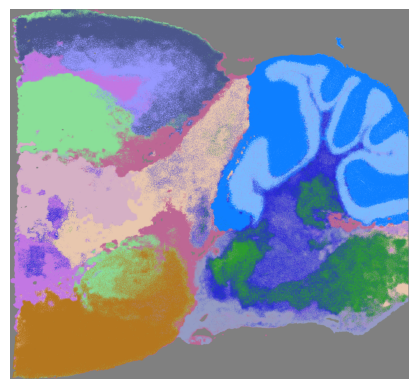

In [9]:
mapper.cluster(use_score='SpaHDmap', resolution=0.8, show=True)

The parameters of the `cluster` function are as follows:
- `section`: the STData object or the name of the section
- `use_score`: the score to use for clustering, default is 'SpaHDmap'
- `n_neighbors`: the number of neighbors, default is 50
- `resolution`: the resolution for clustering, default is 0.8
- `show`: whether to show the clustering results, default is True

The scaled SpaHDmap pixel clustering results are stored in the `clusters` attribute of the STData object.

In [14]:
mouse_posterior.clusters['SpaHDmap']['pixel'].shape

(1999, 2155)

Finally, we can save (and load) the STData object using:

In [ ]:
# Save the STData object
mouse_posterior.save(results_path + 'mouse_posterior.st')
# Load the STData object
# mouse_posterior = hdmap.prepare_stdata(st_path=(results_path + 'mouse_posterior.st'))